In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

### Pull in Data

In [23]:
tech_support = pd.read_csv('../data/1646083584_TalesFromTechSupport.csv')
retail = pd.read_csv('../data/1646083610_TalesFromRetail.csv')
tech_support.shape, retail.shape

((1093, 5), (1097, 5))

### Check Data

In [24]:
tech_support.head()

,author,title,selftext,subreddit,created_utc
0,SonDontPlay,"""Where is the router?""",A General Officer calls in for urgent tech sup...,talesfromtechsupport,1638946522
1,talbourne,With users like this...,I'll be staying at this company for a long tim...,talesfromtechsupport,1638904166
2,edhands,Math...what a concept,"Back in 2009, our company purchased a horribly...",talesfromtechsupport,1629488107
3,12altoids34,I'll have you know I've been working on comput...,Thats how the call started. \n\nThen she went ...,talesfromtechsupport,1623803260
4,Gingrpenguin,We need you to tell us our current password. N...,For backstory i worked for a small tech compan...,talesfromtechsupport,1623769022


In [25]:
tech_support.isnull().sum()

author         0
title          0
selftext       0
subreddit      0
created_utc    0
dtype: int64

In [26]:
retail.head()

,author,title,selftext,subreddit,created_utc
0,MattyDGames,Your know card doesn’t work? Let’s grab all th...,"Ok ok, today I had a customer come in with a c...",TalesFromRetail,1638923563
1,MissMissieFatCat,Woman proves herself wrong and storms out of s...,I work in a family owned pet food/supply store...,TalesFromRetail,1623770945
2,Knever,Coworkers try to steal $200 worth of groceries...,"I worked at a grocery store with a guy who, on...",TalesFromRetail,1623707257
3,Mr_jon3s,Moves parking cone gets mad that I yelled at h...,Having some work done on the parking lot so we...,TalesFromRetail,1623594705
4,pessimist_kitty,Getting real tired of people thinking we're ma...,This just happened this morning and I had to s...,TalesFromRetail,1614891256


In [27]:
retail.isnull().sum()

author         0
title          0
selftext       0
subreddit      0
created_utc    0
dtype: int64

In [28]:
df = tech_support.append(retail, ignore_index=True)
df.shape

(2190, 5)

### Select Positive Class

TalesFromTechSupport will be my positive class for these models

In [29]:
df['subreddit'] = df['subreddit'].replace({'TalesFromRetail': 0, 'talesfromtechsupport': 1})
df.head()

,author,title,selftext,subreddit,created_utc
0,SonDontPlay,"""Where is the router?""",A General Officer calls in for urgent tech sup...,1,1638946522
1,talbourne,With users like this...,I'll be staying at this company for a long tim...,1,1638904166
2,edhands,Math...what a concept,"Back in 2009, our company purchased a horribly...",1,1629488107
3,12altoids34,I'll have you know I've been working on comput...,Thats how the call started. \n\nThen she went ...,1,1623803260
4,Gingrpenguin,We need you to tell us our current password. N...,For backstory i worked for a small tech compan...,1,1623769022


In [30]:
df['subreddit'].value_counts(normalize=True)

0    0.500913
1    0.499087
Name: subreddit, dtype: float64

Nice even split of data, providing good grounds for evaluation of the models.

### Clean Data

In [31]:
# From Breakfast Hour lecture https://git.generalassemb.ly/DSIR-0124/Breakfast-Hour/blob/master/06-week/MON%20-%20S%20-%20NLP%20Practice.ipynb

def remove_html(content):
    '''function to remove html and lowercase all text'''
    
    no_html = BeautifulSoup(content).text
    # removes html
    
    lower_case = no_html.lower()
    # lowercase all text
    
    return lower_case

In [32]:
df['clean_title'] = df['title'].apply(remove_html)
df['clean_selftext'] = df['selftext'].apply(remove_html)
df.head()

,author,title,selftext,subreddit,created_utc,clean_title,clean_selftext
0,SonDontPlay,"""Where is the router?""",A General Officer calls in for urgent tech sup...,1,1638946522,"""where is the router?""",a general officer calls in for urgent tech sup...
1,talbourne,With users like this...,I'll be staying at this company for a long tim...,1,1638904166,with users like this...,i'll be staying at this company for a long tim...
2,edhands,Math...what a concept,"Back in 2009, our company purchased a horribly...",1,1629488107,math...what a concept,"back in 2009, our company purchased a horribly..."
3,12altoids34,I'll have you know I've been working on comput...,Thats how the call started. \n\nThen she went ...,1,1623803260,i'll have you know i've been working on comput...,thats how the call started. \n\nthen she went ...
4,Gingrpenguin,We need you to tell us our current password. N...,For backstory i worked for a small tech compan...,1,1623769022,we need you to tell us our current password. n...,for backstory i worked for a small tech compan...


### Separate Train and Test Data

In [33]:
X_t = df['clean_title']
X_st = df['clean_selftext']
y = df['subreddit']

In [34]:
X_train_t, X_test_t, y_train, y_test = train_test_split(X_t, y, random_state=42, stratify=y)
# match up 
X_train_st = X_st[X_train_t.index]
X_test_st = X_st[X_test_t.index]

In [35]:
X_train_st.index == X_train_t.index

array([ True,  True,  True, ...,  True,  True,  True])

### Preliminary Model

In [36]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [38]:
# start with a model using the title and default parameters

pipe.fit(X_train_t, y_train)

Pipeline(steps=[('cvec', CountVectorizer()),
                ('logreg', LogisticRegression(max_iter=1000))])

In [176]:
print('Train Score:', pipe.score(X_train_t, y_train))
print('Test Score:', pipe.score(X_test_t, y_test))
print('Cross-Val Score:', cross_val_score(pipe, X_train_t, y_train).mean())

Train Score: 0.702801461632156
Test Score: 0.6952554744525548
Cross-Val Score: 0.7442249240121581


In [179]:
cross_val = cross_val_score(pipe, X_train_t, y_train)

In [182]:
cross_val.std()*3

0.06951966850402047

Very high variance seen in the model, with training data accurately predicting the subreddit 96% of the time with training data, but only 74% of the time with unseen data.

In [40]:
# let's see how selftext does

pipe.fit(X_train_st, y_train)

Pipeline(steps=[('cvec', CountVectorizer()),
                ('logreg', LogisticRegression(max_iter=1000))])

In [183]:
print('Train Score:', pipe.score(X_train_st, y_train))
print('Test Score:', pipe.score(X_test_st, y_test))
cross_val = cross_val_score(pipe, X_train_st, y_train)
print('Cross-Val Score:', cross_val.mean())

Train Score: 0.9926918392204629
Test Score: 0.9397810218978102
Cross-Val Score: 0.957975016680258


In [197]:
sig_3 = cross_val.std()*3
print('Cross-Val Standard Deviation:', '{:.4f}'.format(cross_val.std()))
print('Accuracy range between:', '{:.2f}'.format(cross_val.mean() - sig_3), 'and', '{:.2f}'.format(cross_val.mean() + sig_3))

Cross-Val Standard Deviation: 0.0138
Accuracy range between: 0.92 and 1.00


Wow, much better. As expected, the volume of the text has a significant affect on performance. Still a bit of variance, but already the model is doing an excellent job predicting unseen data with 94% accuracy. We are overfitting a bit it seems, with 99% accuracy on the training data, so we may be able to squeeze some performance by stripping out some of the features (maybe with LASSO).

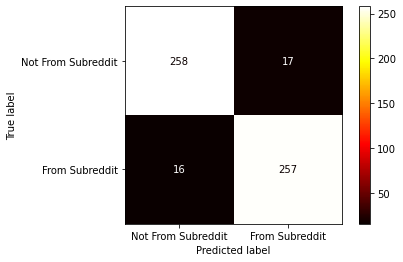

In [74]:
# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(pipe, X_test_st, y_test, cmap='hot', display_labels=('Not From Subreddit', 'From Subreddit'))

In [78]:
pred = pipe.predict(X_test_st)

In [80]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       275
           1       0.94      0.94      0.94       273

    accuracy                           0.94       548
   macro avg       0.94      0.94      0.94       548
weighted avg       0.94      0.94      0.94       548



This basic logistic regression model outperforms the baseline (50% accuracy when guessing all posts are not from the target subreddit) with 94% accuracy, and is balanced in its false positive/false negative rates with 94% precision and 94% recall rates. We already have a solid model for predicting post origin based on these results. 

### Tune Model

I'm going to start by taking a look at what the model's top features based on coefficient magnitude

In [96]:
# approach found at https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn
vectorizer = pipe.named_steps['cvec']
classifier = pipe.named_steps['logreg']
coefs_st = classifier.coef_[0]
coefs_st

array([ 7.91402767e-03, -6.83126089e-02, -2.37074410e-08, ...,
       -8.46863996e-04, -1.55397906e-02, -8.46863996e-04])

In [97]:
coefs_st.shape

(19713,)

In [91]:
features_st = vectorizer.get_feature_names_out()
features_st

In [98]:
features_st.shape

(19713,)

In [107]:
feature_coefs = pd.Series(index=features_st, data=coefs_st)
sorted_features = feature_coefs.sort_values(ascending=False)

In [108]:
sorted_features.head(20)

tech         0.842383
support      0.832082
computer     0.750193
user         0.555967
call         0.498199
laptop       0.484596
power        0.475655
email        0.469996
calls        0.448273
desk         0.423087
computers    0.418817
office       0.402232
new          0.383437
pc           0.369927
removed      0.362786
router       0.356202
ticket       0.352710
crosspost    0.349402
again        0.347519
from         0.345958
dtype: float64

Notably, "computer" and "computers" both make it onto the list (which makes sense as a dead giveaway...) as separate items; I'd be interested in seeing how a stemmer impacts performance. And then the words "tech" and "support" being the top words is certainly no surprise. I hadn't originally considered that "office" would be strongly tied to tech support, but obviously retail business is not typically conducted in an office, so I feel a little silly for not having identified that for myself beforehand. 

In [109]:
sorted_features.tail(20)

were       -0.266657
gift       -0.269113
sir        -0.283790
came       -0.284316
come       -0.287723
them       -0.294136
customer   -0.296085
sale       -0.298438
then       -0.307782
item       -0.320667
items      -0.343231
card       -0.349551
bag        -0.371315
woman      -0.371769
register   -0.376236
cashier    -0.381926
counter    -0.397605
retail     -0.413051
order      -0.416084
store      -1.187742
dtype: float64

The words shown here point away from the target subreddit, and towards our opposing subreddit, "TalesFromRetail". It appears here as well that applying a stemmer could be useful, but otherwise most of the words seem to make sense. Some interesting standouts in "then" and "were" being in this list; curious to me that those would be used more frequently in retail relative to tech support.

In [37]:
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()),
  ('logreg', LogisticRegression(max_iter=1000))],
 'verbose': False,
 'cvec': CountVectorizer(),
 'logreg': LogisticRegression(max_iter=1000),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'logreg__C': 1.0,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 1000,
 'logreg__multi_class': 'auto',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solv

Okay, let's see how cutting down the number of words using a stemmer and dropping stop words in the vectorizer, and using LASSO with the logistic regression, affects things. 

In [111]:
# approach from https://git.generalassemb.ly/DSIR-0124/Breakfast-Hour/blob/master/06-week/MON%20-%20S%20-%20NLP%20Practice.ipynb

def stem_content(content):
    p_stemmer = PorterStemmer()
    split_content = content.split(' ')
    return [p_stemmer.stem(word) for word in split_content]

In [171]:
t_start = int(time.time())

np.random.seed(42)
params1 = {
    'cvec__tokenizer': [None, stem_content],
    'cvec__stop_words': [None, 'english'],
    'logreg__penalty': ['l1'], # LASSO regularization
    'logreg__solver': ['liblinear'], # solver that handles LASSO
    'logreg__C': [1.0, .7, .4]
}

gs1 = GridSearchCV(pipe, params1)
gs1.fit(X_train_st, y_train)

t_finish = int(time.time())
t_delta = t_finish - t_start

print(f'Time to complete: {t_delta // 60} min, {t_delta % 60} seconds')
print(gs1.best_score_)
print(gs1.best_params_)

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sor

C:\Users\musou\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sor

Time to complete: 9 min, 41 seconds
0.9549280895544519
{'cvec__stop_words': 'english', 'cvec__tokenizer': None, 'logreg__C': 0.7, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [188]:
print('Train Score:', gs1.score(X_train_st, y_train))
print('Test Score:', gs1.score(X_test_st, y_test))
print('Cross-Val Score:', gs1.best_score_)

Train Score: 0.9920828258221681
Test Score: 0.9525547445255474
Cross-Val Score: 0.9549280895544519


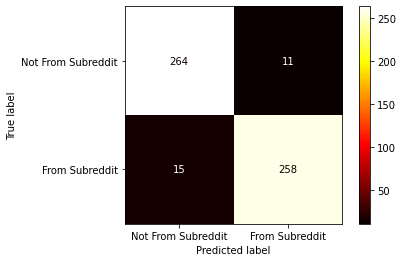

In [201]:
ConfusionMatrixDisplay.from_estimator(gs1, X_test_st, y_test, cmap='hot', display_labels=('Not From Subreddit', 'From Subreddit'))

In [193]:
# approach from https://git.generalassemb.ly/DSIR-0124/lesson-hyperparameters-gridsearch-and-pipelines/blob/master/starter-code.ipynb

pd.DataFrame(gs1.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__stop_words,param_cvec__tokenizer,param_logreg__C,param_logreg__penalty,param_logreg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.620963,0.011011,0.130335,0.003037,english,None,0.7,l1,liblinear,"{'cvec__stop_words': 'english', 'cvec__tokeniz...",0.957447,0.960486,0.948171,0.960366,0.948171,0.954928,0.005624,1
8,0.616761,0.009547,0.129357,0.004140,english,None,0.4,l1,liblinear,"{'cvec__stop_words': 'english', 'cvec__tokeniz...",0.954407,0.963526,0.945122,0.960366,0.951220,0.954928,0.006537,2
6,0.618787,0.019818,0.129939,0.004459,english,None,1.0,l1,liblinear,"{'cvec__stop_words': 'english', 'cvec__tokeniz...",0.954407,0.960486,0.948171,0.957317,0.951220,0.954320,0.004346,3
0,0.703402,0.015770,0.143528,0.006482,None,None,1.0,l1,liblinear,"{'cvec__stop_words': None, 'cvec__tokenizer': ...",0.942249,0.948328,0.935976,0.966463,0.954268,0.949457,0.010463,4
1,0.703039,0.012355,0.144097,0.008094,None,None,0.7,l1,liblinear,"{'cvec__stop_words': None, 'cvec__tokenizer': ...",0.942249,0.948328,0.932927,0.969512,0.954268,0.949457,0.012262,4


Not much difference there, with the particular exception that english stop words significantly reduced the cross_val standard deviation. On our original model, we were seeing a standard deviation of around .014, and this new model more than halves that down to .006. This is great; the overall variance of our model is diminishing, even though we aren't yet seeing much affect on our train and test scores.

Also of note, the Train score remains very close to perfect; I want to try and push that down away from overfitting and try to give some room to swap bias for variance (thinking that will bring the cross-val and test scores up along the way)

In [192]:
gs1.best_estimator_[0]

CountVectorizer(stop_words='english')

In [191]:
gs1.best_estimator_[1]

LogisticRegression(C=0.7, max_iter=1000, penalty='l1', solver='liblinear')

For our count vectorizor, stemming didn't appear to help much, but stop words certainly helped with variance. Next, I'd like to get a little better resolution on regularization strength values, and try to cut down features a bit more.

In [198]:
t_start = int(time.time())

np.random.seed(42)
params2 = {
#     'cvec__tokenizer': [None, stem_content], # tokenizer didn't seem to help
    'cvec__stop_words': ['english'], # english stop words bought down our standard deviation considerably
    'logreg__penalty': ['l1'], # LASSO regularization
    'logreg__solver': ['liblinear'], # solver that handles LASSO
    'logreg__C': [.8, .7, .6, .5, .4, .3, .2, .1]
}

gs2 = GridSearchCV(pipe, params2)
gs2.fit(X_train_st, y_train)

t_finish = int(time.time())
t_delta = t_finish - t_start

print(f'Time to complete: {t_delta // 60} min, {t_delta % 60} seconds')
print(gs2.best_score_)
print(gs2.best_params_)

Time to complete: 0 min, 33 seconds
0.956145748387575
{'cvec__stop_words': 'english', 'logreg__C': 0.6, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [199]:
print('Train Score:', gs2.score(X_train_st, y_train))
print('Test Score:', gs2.score(X_test_st, y_test))
print('Cross-Val Score:', gs2.best_score_)

Train Score: 0.9908647990255786
Test Score: 0.9525547445255474
Cross-Val Score: 0.956145748387575


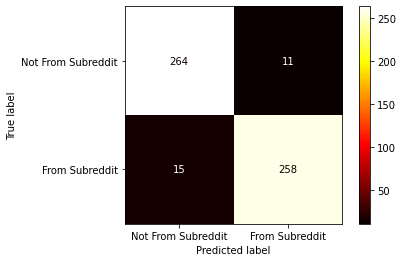

In [202]:
ConfusionMatrixDisplay.from_estimator(gs2, X_test_st, y_test, cmap='hot', display_labels=('Not From Subreddit', 'From Subreddit'))

In [200]:
pd.DataFrame(gs2.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__stop_words,param_logreg__C,param_logreg__penalty,param_logreg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.662143,0.009502,0.141446,0.014434,english,0.6,l1,liblinear,"{'cvec__stop_words': 'english', 'logreg__C': 0...",0.957447,0.963526,0.948171,0.960366,0.951220,0.956146,0.005689,1
3,0.660284,0.009097,0.142618,0.005246,english,0.5,l1,liblinear,"{'cvec__stop_words': 'english', 'logreg__C': 0...",0.954407,0.960486,0.948171,0.960366,0.951220,0.954930,0.004902,2
1,0.671227,0.011355,0.144629,0.006419,english,0.7,l1,liblinear,"{'cvec__stop_words': 'english', 'logreg__C': 0...",0.957447,0.960486,0.948171,0.960366,0.948171,0.954928,0.005624,3
4,0.664808,0.030719,0.145820,0.006421,english,0.4,l1,liblinear,"{'cvec__stop_words': 'english', 'logreg__C': 0...",0.954407,0.960486,0.945122,0.960366,0.951220,0.954320,0.005810,4
0,0.661031,0.005593,0.141836,0.004064,english,0.8,l1,liblinear,"{'cvec__stop_words': 'english', 'logreg__C': 0...",0.954407,0.960486,0.945122,0.960366,0.948171,0.953710,0.006247,5


Okay, looks like we're starting to split hairs with the regularization strengths. Seeing solid performance with the top two grid searched models producing around 95.5% accuracy, with a standard deviation around .5%.  

One last thing I'd like to try with this logistic regression model is to incorporate n-grams; I suspect that there are a number of word combinations that would be strong indicators for our subreddits. 

In [ ]:
t_start = int(time.time())

np.random.seed(42)
params3 = {
    'cvec__stop_words': ['english'], # english stop words bought down our standard deviation considerably
    'cvec__ngram_range': [(2,2), (1,2)] # explore two-word space
    'logreg__penalty': ['l1'], # LASSO regularization
    'logreg__solver': ['liblinear'], # solver that handles LASSO
    'logreg__C': [.6, .55, .5] # exploring the space between the two previous best regularization strengths (assuming indepence from other params)
}

gs3 = GridSearchCV(pipe, params3)
gs3.fit(X_train_st, y_train)

t_finish = int(time.time())
t_delta = t_finish - t_start

print(f'Time to complete: {t_delta // 60} min, {t_delta % 60} seconds')
print(gs3.best_score_)
print(gs3.best_params_)